# Machine Learning Sentiment Analysis

## Introduction

This project will explore the posibility of using deep learning to perform sentiment analysis. This is a supervised learning project that will use the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) dataset from Kaggle. The goal of this project will be to classify the sentiment of tweets and to learn more about building deep learning models.

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer

import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading a dataset

This dataset contains 1.6 million tweets, each tagged with a sentiment, either positive or negative. The only columns we care about in this dataset are the tweets and the sentiment.

In [12]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])

In [13]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
dataset = np.asarray([df['target'], df['text']])
dataset.shape

(2, 1600000)

In [15]:
dataset = dataset.T
dataset[:5]

array([[0,
        "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"],
       [0,
        "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"],
       [0,
        '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'],
       [0, 'my whole body feels itchy and like its on fire '],
       [0,
        "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]],
      dtype=object)

## Data cleaning

I will start by cleaning the data by lower casing each word, since casing isn't important to the meaning of the word. I will also be replacing things like Twitter user handles and hashtags with generic tokens. This is because each word needs its own word embedding and it will not be possible to generate word embeddings for every user and hashtag used in the dataset. There are more data cleaning method I could apply here like replacing emojis with an emoji token, however that would take too much time for probably not that big of a difference on performance.


In [16]:
def preprocess(tweet):
    #Regex patterns
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    hashPattern       = '#[^\s]+'
    
    tweet = tweet.lower()
    #Replace URl's with 'url'
    tweet = re.sub(urlPattern, 'url', tweet)
    #Replace @USERNAME with 'user'
    tweet = re.sub(userPattern, 'user', tweet)
    #Replace #Hashtags with 'hashtag'
    tweet = re.sub(hashPattern, 'hashtag', tweet)
    #Remove all non alphabet characters
    tweet = re.sub(alphaPattern, ' ', tweet)
    
    return tweet

In [17]:
print('Unprocessed tweet: ' + dataset[0][1])
print('Processed tweet: ' + preprocess(dataset[0][1]))

Unprocessed tweet: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed tweet: user url   awww  that s a bummer   you shoulda got david carr of third day to do it   d


In [18]:
#This will take a few minutes
for i in range(dataset.shape[0]):
    dataset[i][1] = preprocess(dataset[i][1])

## EDA

Here I have some basic EDA just to get a better idea of the data I am working with. There will be more EDA later in the notebook.

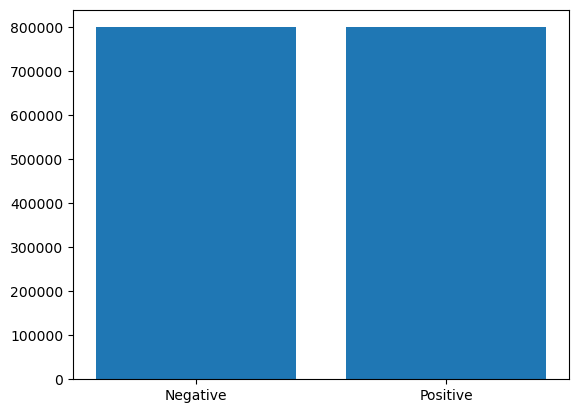

In [19]:
num_neg = len(df[df['target']==0])
num_pos = len(df[df['target']==4])

fig = plt.figure()
plt.bar(['Negative', 'Positive'],[num_neg, num_pos])
plt.show()

In [20]:
def gen_wordcloud(data):
    plt.figure(figsize = (20,20))
    wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
                   collocations=False).generate(" ".join(data))
    plt.imshow(wc)

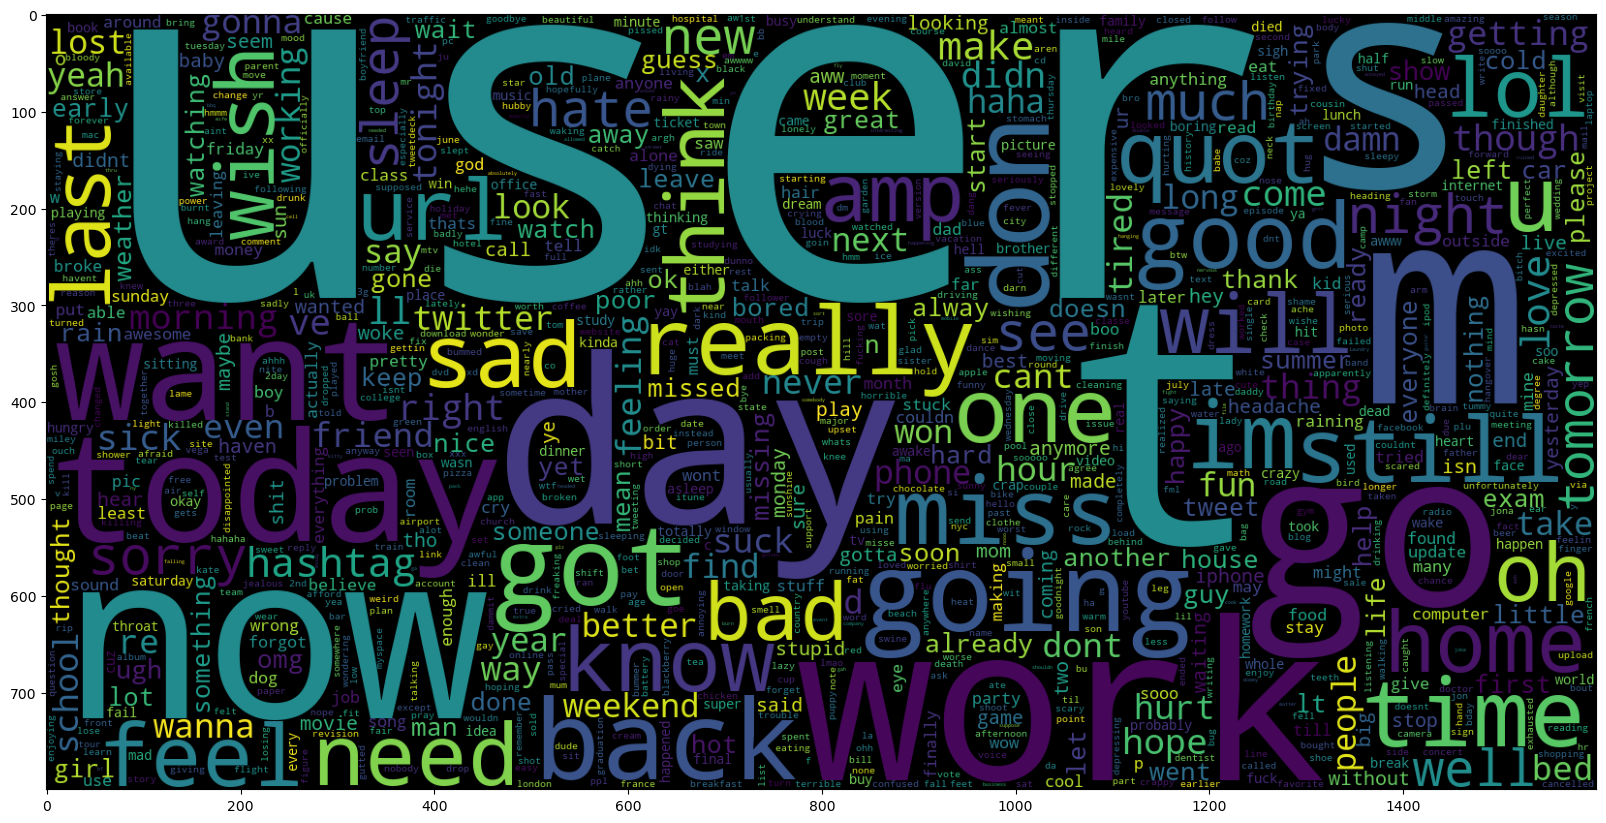

In [21]:
#Wordcloud for negative examples
gen_wordcloud(dataset[:800000, 1])

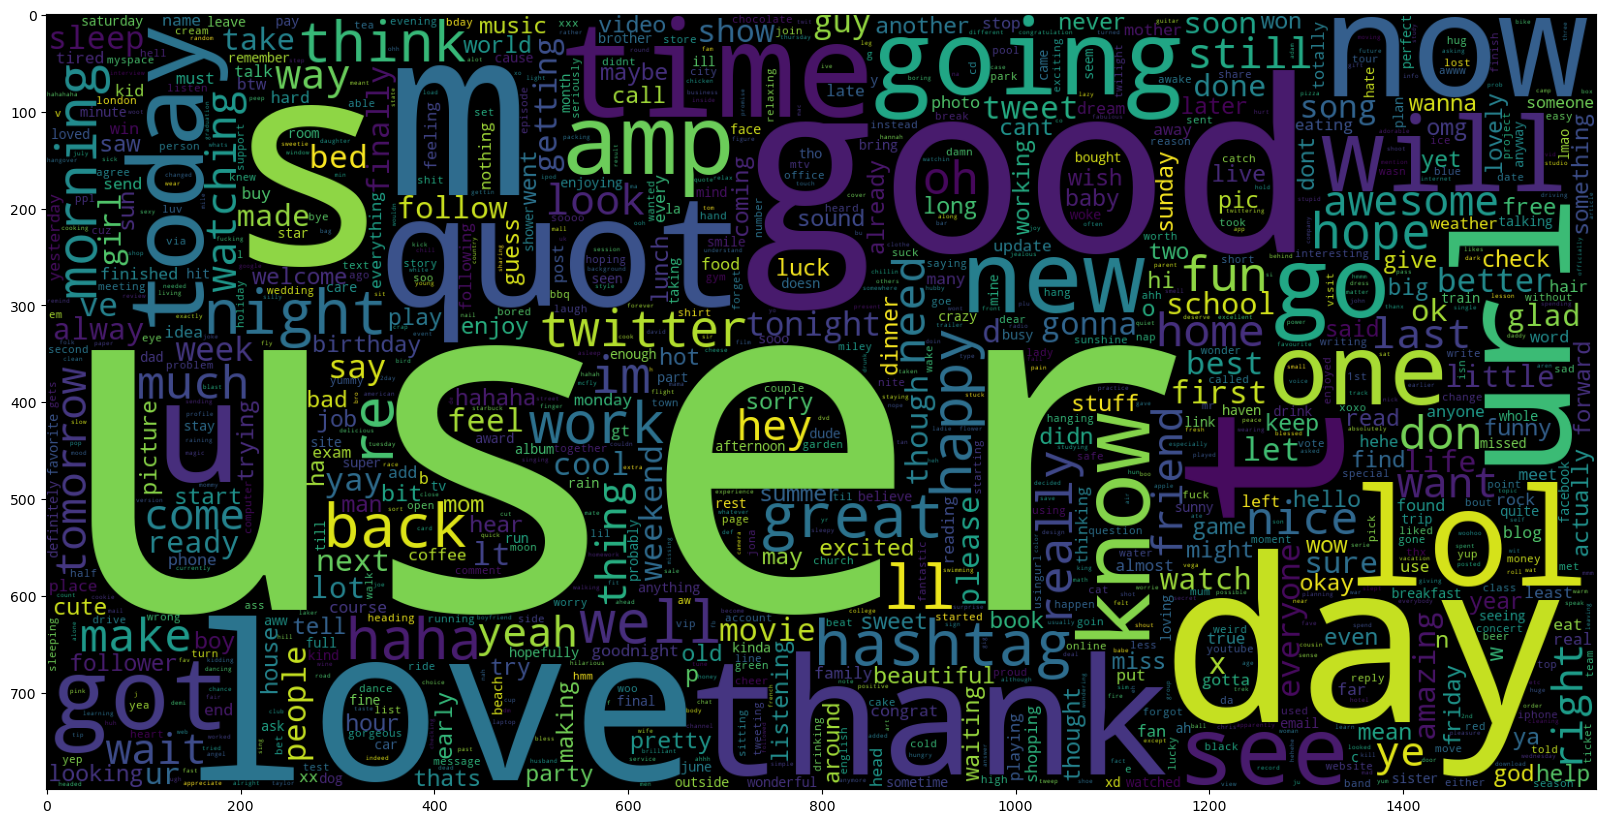

In [22]:
#Wordcloud for positive examples
gen_wordcloud(dataset[800000:, 1])

## Feature Engineering and Cosine similarity

Here I load in the [GloVe](https://github.com/stanfordnlp/GloVe) word embeddings. And since word embeddings are just vectors we can use cosine similarity to find words similar to eachother.

In [23]:
vocabulary = set()
for example in dataset[:, 1]:
    for word in example.split():
        vocabulary.add(word)
print(len(vocabulary))

274975


In [24]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            if curr_word not in vocabulary:
                continue
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 0
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    
    return words_to_index, index_to_words, word_to_vec_map

In [26]:
word_to_index, index_to_word, word_to_vec = read_glove_vecs('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt')

In [27]:
len(index_to_word)

97230

In [28]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_most_similar_words(word, top=5):
    most_similar = []
    max_sim = -1
    vec = word_to_vec[word]
    for key in word_to_vec.keys():
        if key == word:
            continue
        
        sim = cosine_similarity(vec, word_to_vec[key])
        
        if len(most_similar) < top:
            most_similar.append([key, sim])
            most_similar.sort(key=lambda x:x[1], reverse=True)
        else:
            if sim > most_similar[top-1][1]:
                most_similar.append([key, sim])
                most_similar.sort(key=lambda x:x[1], reverse=True)
                most_similar.pop()
    return most_similar

In [29]:
get_most_similar_words('pakistan', top=10)

[['india', 0.8370324451977647],
 ['pakistani', 0.8126390522239408],
 ['bangladesh', 0.778174275284951],
 ['lanka', 0.7608243904434348],
 ['sri', 0.7298580285312779],
 ['afghanistan', 0.7257570923523847],
 ['islamabad', 0.7255539564798297],
 ['kashmir', 0.7038477641044242],
 ['delhi', 0.674337068561223],
 ['iran', 0.6704538525181301]]

In [30]:
get_most_similar_words('cow', top=10)

[['cows', 0.7541886195505594],
 ['pig', 0.7517360922110291],
 ['mad', 0.7499966341274197],
 ['sheep', 0.7310901475622236],
 ['pigs', 0.727885837248785],
 ['bovine', 0.7249353085597959],
 ['cattle', 0.7192908974675003],
 ['goat', 0.7043229379057235],
 ['chickens', 0.6818841608569822],
 ['poultry', 0.6818820112114762]]

In [31]:
get_most_similar_words('king', top=10)

[['prince', 0.7682328871092982],
 ['queen', 0.7507690793623849],
 ['son', 0.7020888440590715],
 ['brother', 0.6985775583353862],
 ['monarch', 0.6977890526652837],
 ['throne', 0.6919990529631601],
 ['kingdom', 0.6811409602269128],
 ['father', 0.6802029120202061],
 ['emperor', 0.6712857804887573],
 ['ii', 0.6676074132713643]]

## Naive Bayes

Sentimental Analysis can be done with very simple algorithms like Naive Bias. This is the first of 2 models I am using.

In [75]:
from sklearn.model_selection import train_test_split
cv = CountVectorizer(stop_words='english',ngram_range = (1,1))
data = cv.fit_transform(dataset[:, 1])

In [76]:
dataset[:, 0][800000:] = 1
labels = dataset[:, 0]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.10, random_state=1)
y_train = np.int32(y_train)
y_test = np.int32(y_test)

In [78]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *

cnb = ComplementNB()
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, data, labels, n_jobs = -1)
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

Train accuracy =79.51%
Test accuracy =76.93%


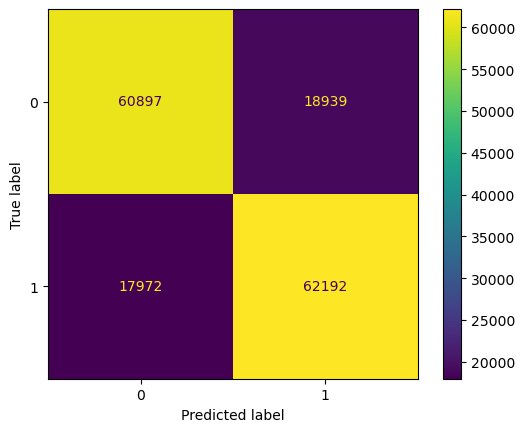

In [38]:
from sklearn.metrics import *
y_pred_cnb =cnb.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_cnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

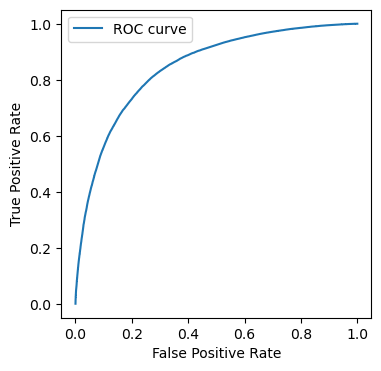

In [39]:
from sklearn.metrics import roc_curve
fpr_dt_1, tpr_dt_1,_ = roc_curve(y_test,cnb.predict_proba(X_test)[:,1])
plt.plot(fpr_dt_1,tpr_dt_1,label="ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.gcf().set_size_inches(4, 4)
plt.show()

## More Data Prep

Here I am just getting the data ready for Deep Learning. Mainly just creating the embedding matrix and padding each sequence to be the same length.

In [40]:
embedding_matrix = []
for word in word_to_index.keys():
    embedding_matrix.append(word_to_vec[word])

In [41]:
max_length = 0
for example in dataset[:, 1]:
    if len(example.split()) > max_length:
        max_length = len(example.split())

In [42]:
max_length

53

In [43]:
def string_to_tokens(string):
    out = []
    for word in string.split():
        if word in word_to_index.keys():
            out.append(word_to_index[word])
    return out

In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset[:, 1], dataset[:, 0], test_size = 0.10, random_state=1)
y_train = np.int32(y_train)
y_test = np.int32(y_test)

In [45]:
def data_prep(data):
    for i in range(len(data)):
        arr = string_to_tokens(data[i])
        arr = np.pad(arr, (55 - len(arr), 0), 'constant')
        data[i] = arr
    return data

In [46]:
X_train = data_prep(X_train)
X_test = data_prep(X_test)

In [47]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 61674, 56447, 32204, 64995, 45989,
       36134, 42589, 33068, 87954,  5546, 86382, 44251, 74505, 40549,
       87038])

In [48]:
def tokens_to_string(tokens):
    out = ''
    for token in tokens:
        out += index_to_word[token] + ' '
    return out

In [49]:
embedding_matrix[0] = np.zeros((len(embedding_matrix[0])))

In [50]:
embedding_matrix = np.asarray(embedding_matrix)
embedding_matrix.shape

(97230, 100)

In [51]:
X_train.shape

(1440000,)

In [52]:
x_train_data = []
for x in X_train:
    x_train_data.append([k for k in x])

In [53]:
x_train_data = np.asarray(x_train_data)
x_train_data.shape

(1440000, 55)

In [54]:
x_test_data = []
for x in X_test:
    x_test_data.append([k for k in x])
x_test_data = np.asarray(x_test_data)
x_test_data.shape

(160000, 55)

## Deep Learning

Finally I am ready to begin deep learning. I build an RNN with LSTM recurrent units and load the pretrained embeddings into the model. I then train for 30 epochs.

In [55]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split

class RNN(nn.Module):
    def __init__(self, embeddings, LSTM_dim, n_layers, bidirectional):
        super().__init__()
        
        self.embedding = nn.Embedding(embeddings.shape[0], embeddings.shape[1])
        self.embedding.load_state_dict({'weight': embeddings})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embeddings.shape[1], LSTM_dim, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(LSTM_dim, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_x):
        # input_x is expected to be of size (example length, batch size) however the axes are
        # flipped so we permute them to be the correct size.
        embedded = self.embedding(input_x.permute(1,0)) 
        # embedded size = (example length, batch size, embedding dimensions)
        output, (hidden, cell) = self.lstm(embedded)
        # hidden size = (number of layers * number of directions, batch size, number of hidden units)
        output = self.dropout(hidden[-1])
        # output size = (batch size, number of hidden units)
        output = self.fc(output)
        # output size = (batch size, 1)
        output = self.sigmoid(output)
        
        return output

In [56]:
#print(sum(p.numel() for p in model.parameters()), 'Million parameters')

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = RNN(torch.tensor(embedding_matrix), 128, 1, False).to(device)

cuda


In [58]:
batch_size = 3000
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [59]:
class CustomDataset(Dataset):
    def __init__(self, examples, labels):
        self.examples = examples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        example = torch.IntTensor(self.examples[idx])
        label = self.labels[idx]
        
        return example, label

In [60]:
train_dataset = CustomDataset(x_train_data, y_train)
test_dataset = CustomDataset(x_test_data, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
#model.load_state_dict(torch.load('model.pt'))

In [62]:
def train(epochs):
    for epoch in range(epochs):
        for i, (batch, labels) in enumerate(train_dataloader):
            batch, labels = batch.to(device), labels.to(device)
            labels = labels.reshape((len(labels), 1))
            labels = labels.float()
            
            model.zero_grad()
            
            output = model(batch)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            if i == 0:
                print(f'Epoch: {epoch+1}/{epochs} Loss: {loss}')

In [63]:
train(30)

Epoch: 1/30 Loss: 0.6932952404022217
Epoch: 2/30 Loss: 0.5458554029464722
Epoch: 3/30 Loss: 0.5233615040779114
Epoch: 4/30 Loss: 0.5095681548118591
Epoch: 5/30 Loss: 0.4988420307636261
Epoch: 6/30 Loss: 0.49160030484199524
Epoch: 7/30 Loss: 0.48136261105537415
Epoch: 8/30 Loss: 0.4748375117778778
Epoch: 9/30 Loss: 0.47031286358833313
Epoch: 10/30 Loss: 0.46506863832473755
Epoch: 11/30 Loss: 0.4604776203632355
Epoch: 12/30 Loss: 0.4573461413383484
Epoch: 13/30 Loss: 0.45146650075912476
Epoch: 14/30 Loss: 0.450424462556839
Epoch: 15/30 Loss: 0.44737815856933594
Epoch: 16/30 Loss: 0.44641414284706116
Epoch: 17/30 Loss: 0.4406559467315674
Epoch: 18/30 Loss: 0.44055435061454773
Epoch: 19/30 Loss: 0.43679264187812805
Epoch: 20/30 Loss: 0.4358959496021271
Epoch: 21/30 Loss: 0.43358999490737915
Epoch: 22/30 Loss: 0.433133989572525
Epoch: 23/30 Loss: 0.4299781918525696
Epoch: 24/30 Loss: 0.42662313580513
Epoch: 25/30 Loss: 0.42693889141082764
Epoch: 26/30 Loss: 0.42337727546691895
Epoch: 27/30 

## Results and Conclusions

In this final section you can see the results from the deep learning model. The results are decent but underwhelming. If you recall from earlier in the notebook the very basic Naive Bias model achieved an accuracy of 76% on the test set, and here the deep learning method only achieved an accuracy of 80% on the test set. Considering how much more work and computational cost went into deep learning a 4% improvement isn't the best. Some ways to improve this would be to train longer, I dont think the model has converged yet. And I also think I could have done more work preprocessing the data. I definitely learned a lot about deep learning and natural language processing from this project and feel confident I could do better if I remade this project.

In [64]:
def print_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            total += len(labels)
            for i in range(len(labels)):
                if labels[i] == outputs[i][0]:
                    correct += 1
    print(correct / total)

In [65]:
print_accuracy(train_dataloader)

/tmp/ipykernel_28/3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.8010125


In [66]:
print_accuracy(test_dataloader)

/tmp/ipykernel_28/3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.7993125


In [ ]:
cnb.predict_proba(X_test)[:,1]

In [67]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [69]:
def cm(dataloader):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            for i in range(len(labels)):
                if outputs[i] == True:
                    if labels[i] == True:
                        true_pos += 1
                    else:
                        false_pos += 1
                else:
                    if labels[i] == False:
                        true_neg += 1
                    else:
                        false_neg += 1
    return np.asarray([[true_neg, false_neg], [false_pos, true_pos]])

In [70]:
cm_ = cm(test_dataloader)

/tmp/ipykernel_28/1465458185.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


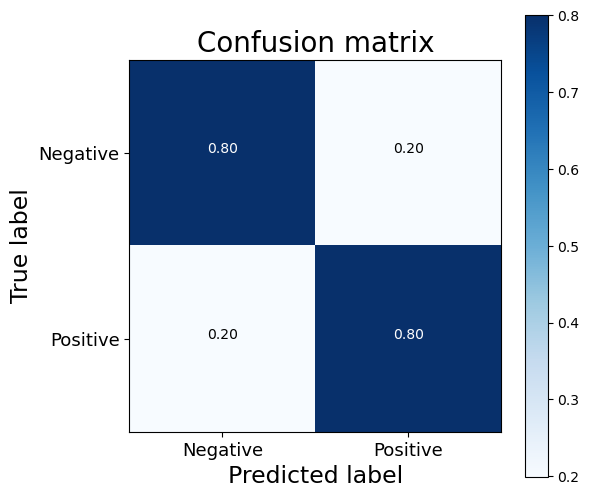

In [73]:
cnf_matrix = np.asarray(cm_)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion matrix")
plt.show()

<IPython.core.display.Javascript object>


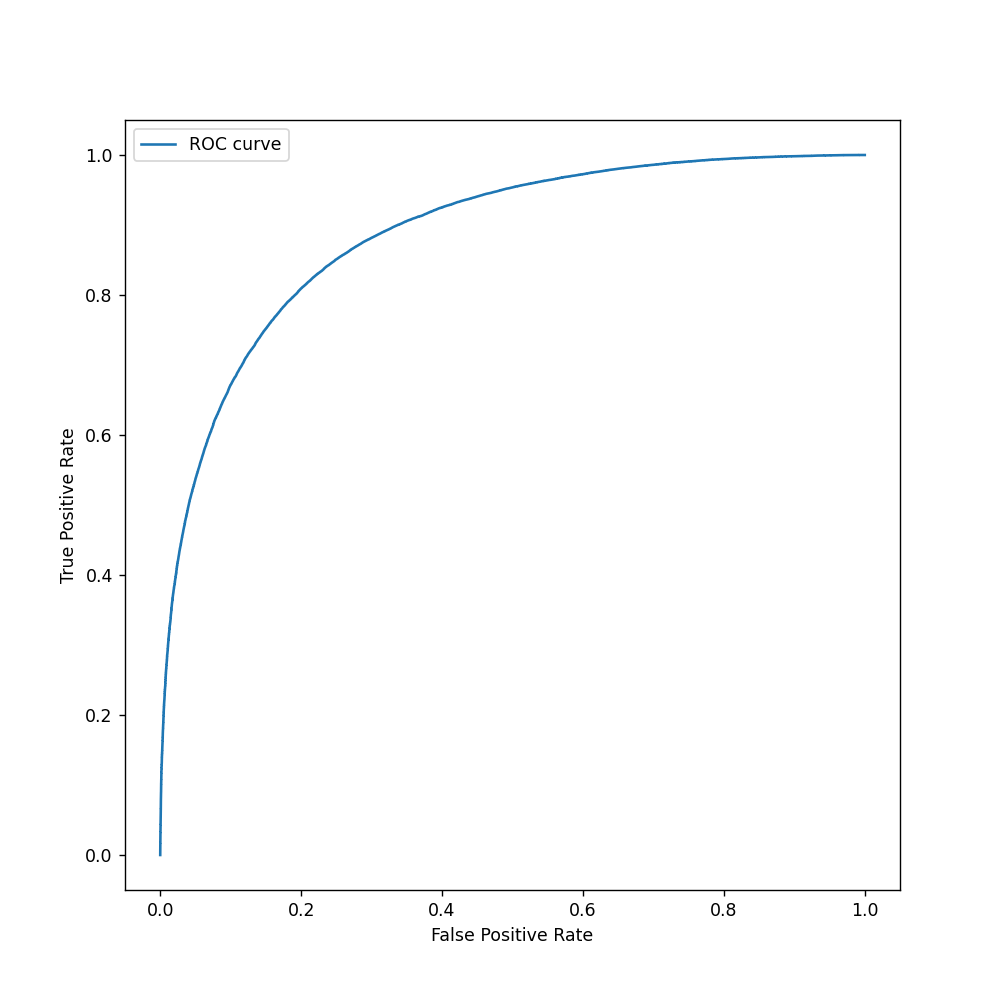

160000


In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
%matplotlib notebook

def roc(labels, predictions):
    fpr_dt_1, tpr_dt_1, _ = roc_curve(predictions, labels)
    plt.plot(fpr_dt_1, tpr_dt_1, label="ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.gcf().set_size_inches(8, 8)
    plt.show()
roc(out, pred)
print(len(pred))